# BEE 4880 Final Project 
Ada Lian and Adam Kulaczkowski 

May 11, 2021 

Economic dispatch model analysis for the NYS March 

## Current economic dispatch

In [4]:
# load necessary packages
import Pkg; Pkg.add("PrettyTables"); Pkg.add("VegaLite")
using JuMP, GLPK
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
ENV["COLUMNS"]=120;

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /Users/adalian/.julia/packages/Plots/SVksJ/src/backends.jl:372


In [16]:
gen_info = CSV.read("Generators_data.csv", DataFrame);
fuels = CSV.read("Fuels_data.csv", DataFrame);
loads_march = CSV.read("NYISO March 2019 Hourly Demand.csv", DataFrame);
loads_august = CSV.read("NYISO August 2019 Hourly Demand.csv", DataFrame);
gen_variable_march = CSV.read("Generators_variability_March.csv", DataFrame);
gen_variable_august = CSV.read("Generators_variability_August.csv", DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads_march, loads_august, gen_variable_march, gen_variable_august]
    rename!(f,lowercase.(names(f)))
end

In [17]:
# Keep only the columns relevant to our ED model 
# (We'll come back to other columns in our unit commitment notebooks)
select!(gen_info, 1:10) # columns 1:10 and cluster IDs
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df[in(["WT","PV","OWT"]).(gen_df.resource),:is_variable] .= true;

# create full name of generator
gen_df.gen_full = lowercase.(gen_df.resource);


In [20]:
gen_variable_long_march = stack(gen_variable_march, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);
# Now we have a "long" dataframe; 
# let's look at the first 6 entries of a wind resource for example
#first(gen_variable_long[gen_variable_long.gen_full.=="wec_sdge_onshore_wind_turbine_1.0",:],6)

In [21]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi(gen_df, loads, gen_variable)
    ED = Model(GLPK.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    # This requires a few extra steps because we are indexing decision variables over two sets: generator and time
    solution = DataFrame(value.(GEN).data)
    ax1 = value.(GEN).axes[1]
    ax2 = value.(GEN).axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    
    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        status = termination_status(ED)
    )

end

economic_dispatch_multi (generic function with 1 method)

In [61]:
#solve a month's economic dispatch (March and August)
T_period_march = 1:nrow(loads_march)

loads_march = loads_march[in.(loads_march.hour,Ref(T_period_march)),:]
gen_variable_march = gen_variable_long_march[in.(gen_variable_long_march.hour,Ref(T_period_march)),:]
;

In [23]:
solution_march = economic_dispatch_multi(gen_df, loads_march, gen_variable_march);

In [62]:
sol_gen_march = innerjoin(solution_march.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_march = combine(groupby(sol_gen_march, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_march, [:hour, :resource])
;

In [25]:
sol_gen_sum = combine(groupby(sol_gen_march, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum   
     │ String?   Float64       
─────┼─────────────────────────
   1 │ CC            2.74651e6
   2 │ ST          844.857
   3 │ GT            0.0
   4 │ JE         9027.7
   5 │ HY            3.88287e6
   6 │ WT            5.54979e5
   7 │ IC         6121.89
   8 │ NP            2.12189e6
   9 │ NB            2.12488e6
  10 │ ES        36450.0
  11 │ PV         7711.4
  12 │ PS            1.0206e6
  13 │ CG            0.0
  14 │ OWT           0.0

In [53]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
renewable = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[8,:gen_sum_sum]+
    sol_gen_sum[9,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[11,:gen_sum_sum]+
    sol_gen_sum[12,:gen_sum_sum]
np = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]
percentage = renewable/tot_demand*100 
percentage_np = np/tot_demand*100 
println("The percentage of total demand can be met using renewable resources is ", percentage, "%")
println("The percentage of total demand can be met using renewable resources not including nuclear is ",
    percentage_np, "%")

The percentage of total demand can be met using renewable resources is 77.92096560532093%
The percentage of total demand can be met using renewable resources not including nuclear is 43.979104352989786%


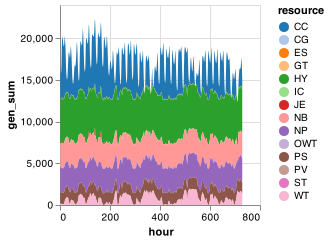

In [27]:
sol_gen_march |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

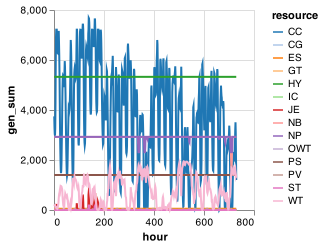

In [28]:
sol_gen_march |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})

In [29]:
solution_march.cost

1.0222862809836939e8

## Offshore Wind Expansion

In [30]:
gen_df_owt = copy(gen_df)
gen_df_owt[gen_df_owt.resource .== "OWT",:existing_cap_mw] .= 4300
solution_march_owt = economic_dispatch_multi(gen_df_owt, loads_march, gen_variable_march);

In [31]:
sol_gen_march_owt = innerjoin(solution_march_owt.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_march_owt = combine(groupby(sol_gen_march_owt, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_march_owt, [:hour, :resource])

10206×3 DataFrame
   Row │ resource  hour   gen_sum  
       │ String?   Int64  Float64  
───────┼───────────────────────────
     1 │ CC            1  3426.03
     2 │ CG            1     0.0
     3 │ ES            1    50.0
     4 │ GT            1     0.0
     5 │ HY            1  5326.3
     6 │ IC            1    11.1
     7 │ JE            1     0.0
     8 │ NB            1  2922.8
     9 │ NP            1  2925.0
    10 │ OWT           1   318.2
    11 │ PS            1  1400.0
   ⋮   │    ⋮        ⋮       ⋮
 10197 │ HY          729  5326.3
 10198 │ IC          729     0.0
 10199 │ JE          729     0.0
 10200 │ NB          729  2262.27
 10201 │ NP          729  2311.0
 10202 │ OWT         729  2476.8
 10203 │ PS          729  1400.0
 10204 │ PV          729     6.667
 10205 │ ST          729     0.0
 10206 │ WT          729  1288.46
                 10185 rows omitted

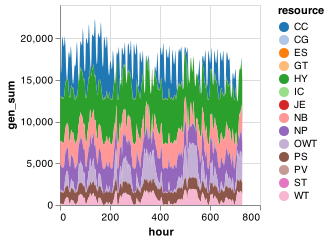

In [44]:
sol_gen_march_owt |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [33]:
solution_march_owt.cost

8.13844146027931e7

In [54]:
sol_gen_sum = combine(groupby(sol_gen_march_owt, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum   
     │ String?   Float64       
─────┼─────────────────────────
   1 │ CC            1.96839e6
   2 │ ST            0.0
   3 │ GT            0.0
   4 │ JE          895.871
   5 │ HY            3.88287e6
   6 │ WT            5.54979e5
   7 │ IC         4137.33
   8 │ NP            2.0392e6
   9 │ NB            1.95563e6
  10 │ ES        36450.0
  11 │ PV         7711.4
  12 │ PS            1.0206e6
  13 │ CG            0.0
  14 │ OWT           1.04101e6

In [56]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
renewable = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[8,:gen_sum_sum]+
    sol_gen_sum[9,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[11,:gen_sum_sum]+
    sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
np = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
percentage = renewable/tot_demand*100 
percentage_np = np/tot_demand*100 
println("The percentage of total demand can be met using renewable resources is ", percentage, "%")
println("The percentage of total demand can be met using renewable resources not including nuclear is ",
    percentage_np, "%")

The percentage of total demand can be met using renewable resources is 84.22758912947059%
The percentage of total demand can be met using renewable resources not including nuclear is 52.29929917327107%


## Deactivation of Nuclear Power Plant 

In [34]:
gen_df_np = copy(gen_df)
gen_df_np[gen_df_np.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_np[gen_df_np.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_march_np = economic_dispatch_multi(gen_df_np, loads_march, gen_variable_march);

In [35]:
sol_gen_march_np = innerjoin(solution_march_np.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_march_np = combine(groupby(sol_gen_march_np, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_march_np, [:hour, :resource])

10206×3 DataFrame
   Row │ resource  hour   gen_sum  
       │ String?   Int64  Float64  
───────┼───────────────────────────
     1 │ CC            1  6047.53
     2 │ CG            1     0.0
     3 │ ES            1    50.0
     4 │ GT            1     0.0
     5 │ HY            1  5326.3
     6 │ IC            1    18.8
     7 │ JE            1     0.0
     8 │ NB            1  2922.8
     9 │ NP            1   614.0
    10 │ OWT           1     0.0
    11 │ PS            1  1400.0
   ⋮   │    ⋮        ⋮       ⋮
 10197 │ HY          729  5326.3
 10198 │ IC          729    11.1
 10199 │ JE          729     0.0
 10200 │ NB          729  2922.8
 10201 │ NP          729   614.0
 10202 │ OWT         729     0.0
 10203 │ PS          729  1400.0
 10204 │ PV          729     6.667
 10205 │ ST          729     0.0
 10206 │ WT          729  1288.46
                 10185 rows omitted

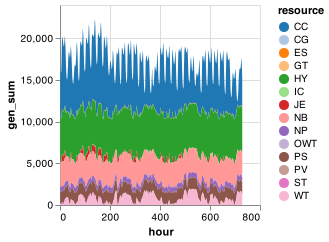

In [36]:
sol_gen_march_np |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [37]:
solution_march_np.cost

1.27164431836943e8

In [57]:
sol_gen_sum = combine(groupby(sol_gen_march_np, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum    
     │ String?   Float64        
─────┼──────────────────────────
   1 │ CC             4.2627e6
   2 │ ST         21986.2
   3 │ GT             0.0
   4 │ JE             1.32497e5
   5 │ HY             3.88287e6
   6 │ WT             5.54979e5
   7 │ IC         13758.8
   8 │ NP        447606.0
   9 │ NB             2.13072e6
  10 │ ES         36450.0
  11 │ PV          7711.4
  12 │ PS             1.0206e6
  13 │ CG             0.0
  14 │ OWT            0.0

In [58]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
renewable = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[8,:gen_sum_sum]+
    sol_gen_sum[9,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[11,:gen_sum_sum]+
    sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
np = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
percentage = renewable/tot_demand*100 
percentage_np = np/tot_demand*100 
println("The percentage of total demand can be met using renewable resources is ", percentage, "%")
println("The percentage of total demand can be met using renewable resources not including nuclear is ",
    percentage_np, "%")

The percentage of total demand can be met using renewable resources is 64.5861368644348%
The percentage of total demand can be met using renewable resources not including nuclear is 43.979104352989744%


## Wind Energy Expansion and Deactivation of Indian Point 

In [38]:
gen_df_combine = copy(gen_df)
gen_df_combine[gen_df_combine.resource .== "OWT",:existing_cap_mw] .= 4300
gen_df_combine[gen_df_combine.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_combine[gen_df_combine.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_march_combine = economic_dispatch_multi(gen_df_combine, loads_march, gen_variable_march);

In [39]:
sol_gen_march_combine = innerjoin(solution_march_combine.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_march_combine = combine(groupby(sol_gen_march_combine, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_march_combine, [:hour, :resource])

10206×3 DataFrame
   Row │ resource  hour   gen_sum  
       │ String?   Int64  Float64  
───────┼───────────────────────────
     1 │ CC            1  5737.03
     2 │ CG            1     0.0
     3 │ ES            1    50.0
     4 │ GT            1     0.0
     5 │ HY            1  5326.3
     6 │ IC            1    11.1
     7 │ JE            1     0.0
     8 │ NB            1  2922.8
     9 │ NP            1   614.0
    10 │ OWT           1   318.2
    11 │ PS            1  1400.0
   ⋮   │    ⋮        ⋮       ⋮
 10197 │ HY          729  5326.3
 10198 │ IC          729     0.0
 10199 │ JE          729     0.0
 10200 │ NB          729  2922.8
 10201 │ NP          729   614.0
 10202 │ OWT         729  2476.8
 10203 │ PS          729  1400.0
 10204 │ PV          729     6.667
 10205 │ ST          729     0.0
 10206 │ WT          729  1288.46
                 10185 rows omitted

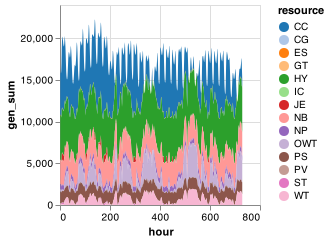

In [40]:
sol_gen_march_combine |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [41]:
solution_march_combine.cost

1.0338199688691936e8

In [59]:
sol_gen_sum = combine(groupby(sol_gen_march_combine, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum   
     │ String?   Float64       
─────┼─────────────────────────
   1 │ CC            3.3514e6
   2 │ ST        11102.1
   3 │ GT            0.0
   4 │ JE        71981.0
   5 │ HY            3.88287e6
   6 │ WT            5.54979e5
   7 │ IC        10787.1
   8 │ NP            4.22634e5
   9 │ NB            2.10035e6
  10 │ ES        36450.0
  11 │ PV         7711.4
  12 │ PS            1.0206e6
  13 │ CG            0.0
  14 │ OWT           1.04101e6

In [60]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
renewable = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[8,:gen_sum_sum]+
    sol_gen_sum[9,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[11,:gen_sum_sum]+
    sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
np = sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+sol_gen_sum[10,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]
percentage = renewable/tot_demand*100 
percentage_np = np/tot_demand*100 
println("The percentage of total demand can be met using renewable resources is ", percentage, "%")
println("The percentage of total demand can be met using renewable resources not including nuclear is ",
    percentage_np, "%")

The percentage of total demand can be met using renewable resources is 72.46402235024607%
The percentage of total demand can be met using renewable resources not including nuclear is 52.29929917327104%
